**Llama 2 Fine-Tuning using QLora_7b version **

需要先註冊以下平台才能使用:
- colab ([https://colab.research.google.com/?hl=zh-tw](https://colab.research.google.com/?hl=zh-tw))
- huggingface ([https://huggingface.co/](https://huggingface.co/))
- w&b ([https://wandb.ai/home](https://wandb.ai/home))
- Meta Llama2授權 ([https://ai.meta.com/resources/models-and-libraries/llama/](https://ai.meta.com/resources/models-and-libraries/llama/))

 Meta會依你提供的e-mail授權你讀取huggingface的meta資料

In [ ]:
!nvidia-smi

Sat Nov 18 09:00:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Finetune Llama-2-7b on a Google colab

在這個範例中將示範如何用Google colab的單一個GPU來微調Llama-2-7b模型，我們將運用PEFT及bitsandbytes等套件來進行QLoRA微調。

## 安裝環境套件

執行以下的程式區塊來設置並安裝所需的套件(library)。在我們的範例中，我們需要使用到 `accelerate`、`peft`、`transformers`、`datasets` 和 `TRL` 來利用最近的 [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer)。我們將使用 `bitsandbytes` 來[將基礎模型量化為4位元](https://huggingface.co/blog/4bit-transformers-bitsandbytes)。你可能還需要安裝 `sentencepiece`，因為它是LlamaTokenizer需要使用到的套件。

另外介紹一下若想要運用一些模型訓練的觀測平台，可以安裝`wandb`這個套件。該平台網址w&b ([https://wandb.ai/home](https://wandb.ai/home))。

w&b是一個能提供模型訓練階段的log記錄存放及視覺化顯示的工具平台，它支援的數值呈垷格式會比Huggingface hub上面的tensorboard還多。而且`transformers`有支援w&b，當你有安裝`wandb`在執行訓練時，會要求你輸入w&b個人帳號的token。之後訓練資訊(log)就會上傳到該平台了。


In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes sentencepiece wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### login huggingface_hub

In [ ]:
from huggingface_hub import login
login()

## 載入資料集

huggingface: `timdettmers/openassistant-guanaco`

https://huggingface.co/datasets/timdettmers/openassistant-guanaco

2023/10/20 (更新) 一些HF平台上的繁體中文資料集:
- Taiwan-LLaMa模型訓練資料集:(https://huggingface.co/datasets/yentinglin/traditional_mandarin_instructions)
- Erhwen,Kuo個人整理,一些知名的語料集之繁體中文化:(https://huggingface.co/erhwenkuo)
- 網頁新聞,由簡體轉繁體(文化對齊問題請自行評估):(https://huggingface.co/datasets/jed351/Traditional-Chinese-Common-Crawl-Filtered)
- TAIDE計劃-訓練資料集: (https://taide.tw/public/trainData)
- TAIDE計畫-測試資料集:(https://huggingface.co/datasets/taide/TAIDE-14-tasks)

(參考)簡體中文資料集:
- 北京智源人工智能研究院-BAAI DataHub（data.baai.ac.cn）:(https://huggingface.co/datasets/BAAI/COIG-PC)

(參考) github平台上的資源:
- 聯發創新基地（MediaTek Research)(https://github.com/mtkresearch/MR-Models/tree/main)


### 範例資料集

(語料包括:英,中,日,韓) HF連結: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

In [ ]:
from datasets import load_dataset

dataset_name = "timdettmers/openassistant-guanaco" ###Human ,.,,,,,, ###Assistant

#dataset_name = "yentinglin/traditional_mandarin_instructions"

dataset = load_dataset(dataset_name, split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 9846
})

In [ ]:
dataset["text"][57]

'### Human: 布洛芬和对乙酰氨基酚的区别是？### Assistant: 根据维基百科，\n布洛芬（英语：Ibuprofen），是一种非类固醇消炎药（NSAID），常用来止痛、退烧、消炎。可用于治疗经痛、偏头痛，和类风湿性关节炎。\n对乙酰氨基酚（英语：Acetaminophen、Paracetamol、简称：APAP），又称乙酰胺酚、扑热息痛，是一种用于治疗疼痛与发烧的药物。\n这是两种不同的药，详情可以参考维基百科.\n参考链接：\n布洛芬：https://zh.wikipedia.org/wiki/%E5%B8%83%E6%B4%9B%E8%8A%AC\n对乙酰氨基酚：https://zh.wikipedia.org/zh-hans/%E5%AF%B9%E4%B9%99%E9%85%B0%E6%B0%A8%E5%9F%BA%E9%85%9A'

**資料集的文本長度統計**

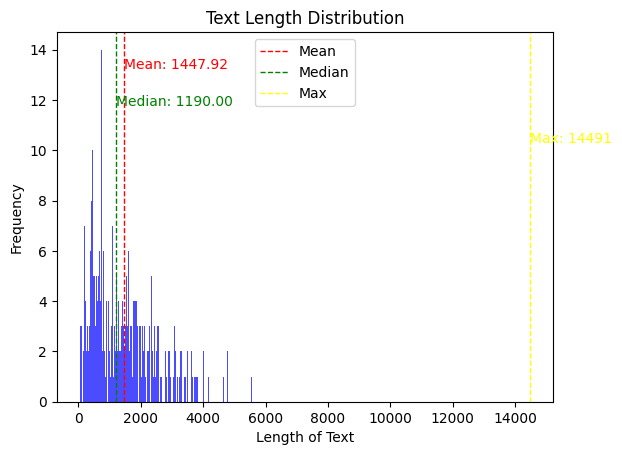

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 計算文本長度
lengths = [len(item['text']) for item in dataset]

# 计算最大值、平均数和中位数
max_length = max(lengths)
mean_length = np.mean(lengths)
median_length = np.median(lengths)

# 绘制长条图
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1, 1), color='blue', alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')

# 在图表上添加注释
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1)
plt.axvline(median_length, color='green', linestyle='dashed', linewidth=1)
plt.axvline(max_length, color='yellow', linestyle='dashed', linewidth=1)

# 创建一个用于图例的小方块，并设置相关标签
plt.legend({'Mean':mean_length,'Median':median_length, 'Max':max_length})

# 添加文本注释
plt.text(mean_length, plt.ylim()[1]*0.9, f'Mean: {mean_length:.2f}', color='red')
plt.text(median_length, plt.ylim()[1]*0.8, f'Median: {median_length:.2f}', color='green')
plt.text(max_length, plt.ylim()[1]*0.7, f'Max: {max_length}', color='yellow')

plt.show()

## 載入模型
meta Llama2: https://huggingface.co/meta-llama

內容生成版本:
- huggingface(7b) https://huggingface.co/meta-llama/Llama-2-7b-hf
- huggingface(13b) https://huggingface.co/meta-llama/Llama-2-13b-hf

對話應用版本:
- huggingface(7b) https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
- huggingface(13b) https://huggingface.co/meta-llama/Llama-2-13b-chat-hf


In [ ]:
'''清除己載入的模型及trainer並清空GPU記憶體
import torch

if 'model' in globals():
    del model

if 'training_arguments' in globals():
    del training_arguments

if 'trainer' in globals():
    del trainer

torch.cuda.empty_cache()
'''

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    #load_in_8bit=True,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map={'': 0},  # 設定使用的設備，此處指定為 GPU 0
    trust_remote_code=True,
)
model.config.use_cache = False

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

### 載入tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding=True)

tokenizer.padding_side = "right"  # 設置padding_side為right，以符合一般文本由左至右的寫作方向
tokenizer.pad_token_id = 2     # 指定pad_token_id=2，與eos_token同一個token
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
tokenizer #刻意讓它的pad_token跟eos_token一樣

LlamaTokenizerFast(name_or_path='meta-llama/Llama-2-7b-chat-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

### 重新整理資料集
因為資料長度太長, 會造成GPU(T4)記憶體不足, 故需把資料集裁成256長度以內.

In [ ]:
import pandas as pd
from datasets import Dataset

# 定义一个函数来裁剪文本
def trim_text(text, max_length):
    return text[:max_length]

# 设置最大长度
MAX_LENGTH = 352

# 裁剪数据集中的每个文本,並在最後強制加上終止符號"</s>"
trimmed_texts = [trim_text(text, MAX_LENGTH)+"</s>" for text in dataset['text']]

# 创建一个新的数据集
# 将裁剪后的文本列表转换为 DataFrame
df = pd.DataFrame({'text': trimmed_texts})

# 使用 datasets 库的 Dataset.from_pandas 方法将 DataFrame 转换为 Dataset
trimmed_dataset = Dataset.from_pandas(df)

In [ ]:
trimmed_dataset

Dataset({
    features: ['text'],
    num_rows: 9846
})

### 設定PEFT-LoRA參數

In [ ]:
from peft import LoraConfig, get_peft_model

lora_r = 8
lora_alpha = 16
lora_dropout = 0.1

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

## 載入trainer

在這裡，我們將使用 TRL 套件中的 [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer)。這個套件提供了一個對 transformers `Trainer` 進行了包裝(wrapper)，方便我們在基於指令的資料集上使用 PEFT 適配器對模型進行微調。首先，讓我們加載以下的訓練參數。

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 1 #使用GPU(T4)只能設為1,否則記憶體OOM
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 100
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,

    push_to_hub=False, #不上傳HF,因為目前(2023.11)還不支援4bits_model
)

Then finally pass everthing to the trainer

參考SFTTrainer的設定說明: https://huggingface.co/docs/trl/sft_trainer

In [ ]:
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

max_seq_length = 384

#如果整理後資料有完整包括Human及Assistant,才採用collator
#instruction_template = "### Human:"
#response_template = "### Assistant:"
#collator = DataCollatorForCompletionOnlyLM(instruction_template=instruction_template, response_template=response_template, tokenizer=tokenizer, mlm=False) #mlm:masked_language_modeling

trainer = SFTTrainer(
    model=model,

    #train_dataset=dataset,
    train_dataset=trimmed_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,

    tokenizer=tokenizer,
    #data_collator=collator,

    peft_config=peft_config,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


Map:   0%|          | 0/9846 [00:00<?, ? examples/s]

In [ ]:
# 查詢函數或模組的使用說明
# ? DataCollatorForCompletionOnlyLM

建議: 把layer name有norm字樣的layer精度改為float32,在訓練時會比較穩定。

In [ ]:
#把layer name有norm字樣的layer精度改為float32,在訓練時會比較穩定。(建議)
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dr

## 訓練模型

In [ ]:
import warnings

# 忽略警告(因為來自資料面的警告太多了...所以關掉一下)
warnings.filterwarnings("ignore")

try:
  trainer.train()
except KeyboardInterrupt:
    print("KeyboardInterrupt")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,2.159300
20,1.953400
30,1.786600
40,1.825500
50,1.810600
60,1.524400
70,1.398700
80,1.639400
90,1.555700
100,1.760300


In [ ]:
#將模型權重存到outputs資料匣
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("outputs")

## 模型推論

In [ ]:
text = "### Human:在未來的2040年,人類社會將進入"
device = "cuda:0"

inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=512)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Human:在未來的2040年,人類社會將進入一個新的階段。在這個階段,人類社會將透過一個「人工智能」的技術，將內心的感情和思想都轉化為數據，並將這些數據輸入人工智能系統，並將其處理和分析。這將導致一個充滿智能和自動化的社會。人類社會將不再需要對內心的感情和思想進行探索和探討，因為人工智能系統可以自動探索和分析這些感情和思想。這將導致一個充滿自動化和智能的社會，人類將不再需要對自己進行探索和探討，因為人工智能系統可以自動進行這些探索和探討。這將導致一個充满自動化和智能的社會，人類將不再需要對自己進行探索和探討，因為人工智能系統可以自動進行這些探索和探討。這將導致一個充满自動化和智能的社會，人類將不再需要對自己進行探索和探討，因為人工智能系統可


In [ ]:
print(inputs)

{'input_ids': tensor([[    1,   835, 12968, 29901, 30505, 31295,   231,   193,   137, 30210,
         29906, 29900, 29946, 29900, 30470, 29892, 30313,   236,   164,   161,
         30564, 31411,   232,   179,   138, 31965, 30752]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [ ]:
inputs.input_ids[0]

tensor([    1,   835, 12968, 29901, 30505, 31295,   231,   193,   137, 30210,
        29906, 29900, 29946, 29900, 30470, 29892, 30313,   236,   164,   161,
        30564, 31411,   232,   179,   138, 31965, 30752], device='cuda:0')

In [ ]:
print(tokenizer.decode(inputs.input_ids[0], skip_special_tokens=False))

<s> ### Human:在未來的2040年,人類社會將進入


In [ ]:
print(tokenizer.decode(outputs[0], skip_special_tokens=False))

<s> ### Human:在未來的2040年,人類社會將進入一個新的階段。在這個階段,人類社會將透過一個「人工智能」的技術，將內心的感情和思想都轉化為數據，並將這些數據輸入人工智能系統，並將其處理和分析。這將導致一個充滿智能和自動化的社會。人類社會將不再需要對內心的感情和思想進行探索和探討，因為人工智能系統可以自動探索和分析這些感情和思想。這將導致一個充滿自動化和智能的社會，人類將不再需要對自己進行探索和探討，因為人工智能系統可以自動進行這些探索和探討。這將導致一個充满自動化和智能的社會，人類將不再需要對自己進行探索和探討，因為人工智能系統可以自動進行這些探索和探討。這將導致一個充满自動化和智能的社會，人類將不再需要對自己進行探索和探討，因為人工智能系統可


瞭解一下資料集輸入的狀況:

In [ ]:
trimmed_dataset['text'][57]

'### Human: 布洛芬和对乙酰氨基酚的区别是？### Assistant: 根据维基百科，\n布洛芬（英语：Ibuprofen），是一种非类固醇消炎药（NSAID），常用来止痛、退烧、消炎。可用于治疗经痛、偏头痛，和类风湿性关节炎。\n对乙酰氨基酚（英语：Acetaminophen、Paracetamol、简称：APAP），又称乙酰胺酚、扑热息痛，是一种用于治疗疼痛与发烧的药物。\n这是两种不同的药，详情可以参考维基百科.\n参考链接：\n布洛芬：https://zh.wikipedia.org/wiki/%E5%B8%83%E6%B4%9B%E8%8A%AC\n对乙酰氨基酚：https://zh.wikipedia.org/zh-hans/%E5%AF%B9%E4%B9%99%E9%85%B0%E6</s>'

In [ ]:
check_token = tokenizer(trimmed_dataset['text'][57], return_tensors="pt")
check_token["input_ids"][0]

tensor([    1,   835, 12968, 29901, 29871, 31454,   233,   183,   158,   235,
          141,   175, 30503, 30783,   231,   188,   156,   236,   136,   179,
          233,   179,   171, 31359,   236,   136,   157, 30210, 30467,   232,
          139,   174, 30392, 30882,  2277, 29937,  4007, 22137, 29901, 29871,
        31393, 30763,   234,   190,   183, 31359, 31047, 31030, 30214,    13,
        31454,   233,   183,   158,   235,   141,   175, 30419, 31144, 31505,
        30383, 29902,  2423,   771, 11350, 30409, 30214, 30392, 30287, 31893,
        31838, 30832,   232,   158,   189,   236,   137,   138, 31276,   234,
          133,   145,   235,   144,   178, 30419,  3059, 29909,  1367, 30409,
        30214, 31190, 30406, 30805, 31981,   234,   154,   158, 30330,   236,
          131,   131,   234,   134,   170, 30330, 31276,   234,   133,   145,
        30267, 30682, 30406, 30909, 31032,   234,   153,   154, 31412,   234,
          154,   158, 30330,   232,   132,   146, 31584,   234, 

In [ ]:
print(tokenizer.decode(check_token["input_ids"][0], skip_special_tokens=False))

<s> ### Human: 布洛芬和对乙酰氨基酚的区别是？### Assistant: 根据维基百科，
布洛芬（英语：Ibuprofen），是一种非类固醇消炎药（NSAID），常用来止痛、退烧、消炎。可用于治疗经痛、偏头痛，和类风湿性关节炎。
对乙酰氨基酚（英语：Acetaminophen、Paracetamol、简称：APAP），又称乙酰胺酚、扑热息痛，是一种用于治疗疼痛与发烧的药物。
这是两种不同的药，详情可以参考维基百科.
参考链接：
布洛芬：https://zh.wikipedia.org/wiki/%E5%B8%83%E6%B4%9B%E8%8A%AC
对乙酰氨基酚：https://zh.wikipedia.org/zh-hans/%E5%AF%B9%E4%B9%99%E9%85%B0%E6</s>




---



## Reference
- Meta AI: Llama 2: open source, free for research and commercial use ([https://ai.meta.com/resources/models-and-libraries/llama/](https://ai.meta.com/resources/models-and-libraries/llama/))
- Meta Llama2 Huggingface model: ([https://huggingface.co/meta-llama](https://huggingface.co/meta-llama))



**Github repository**

- [github] Parameter-Efficient Fine-Tuning (PEFT) ([https://github.com/huggingface/peft](https://github.com/huggingface/peft))
- [github] TRL - Transformer Reinforcement Learning ([https://github.com/lvwerra/trl](https://github.com/lvwerra/trl))
- [github] bitsandbytes ([https://github.com/TimDettmers/bitsandbytes](https://github.com/TimDettmers/bitsandbytes))
- [github] einops ([https://github.com/arogozhnikov/einops](https://github.com/arogozhnikov/einops))
- [github] Meta Llama 2 ([https://github.com/facebookresearch/llama/tree/main](https://github.com/facebookresearch/llama/tree/main))


**Code Credit: Hugging Face**

Dataset Credit: https://twitter.com/Dorialexander/status/1681671177696161794

**others**

- Open LLM Leaderboard ([https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard))
- LLaMA2 Demo by a16z Infra and Replicate. ([https://llama2.ai/](https://llama2.ai/))
- LLaMA2-社群中文版 ([https://github.com/FlagAlpha/Llama2-Chinese](https://github.com/FlagAlpha/Llama2-Chinese))
- 各類colab demo範例可參考([https://github.com/camenduru](https://github.com/camenduru))

**Datasets**
2023/10/20 (更新) 一些HF平台上的繁體中文資料集:
- Taiwan-LLaMa模型訓練資料集:(https://huggingface.co/datasets/yentinglin/traditional_mandarin_instructions)
- Erhwen,Kuo個人整理,一些知名的語料集之繁體中文化:(https://huggingface.co/erhwenkuo)
- 網頁新聞,由簡體轉繁體(文化對齊問題請自行評估):(https://huggingface.co/datasets/jed351/Traditional-Chinese-Common-Crawl-Filtered)
- TAIDE計畫的測試資料集:(https://huggingface.co/datasets/taide/TAIDE-14-tasks)

(參考)簡體中文資料集:
- 北京智源人工智能研究院-BAAI DataHub（data.baai.ac.cn）:(https://huggingface.co/datasets/BAAI/COIG-PC)

(參考) github平台上的資源:
- 聯發創新基地（MediaTek Research)(https://github.com/mtkresearch/MR-Models/tree/main)

# 延伸閱讀

[參考文章] 為什麼不 fine tune 模型?

在做 computer vision 的年代，我們會用 fine tune 的技巧，把自己的資料餵給 CNN（Convolutional Neural Networks），fine tune 模型而得到一個新的模型。而且準確度往往很容易做得很高，細心調整的話，達到 90%以上往往不是一件難事。但是在 LLM 的時代就不太一樣了，如果我們使用 fine tune 的技巧來把自己想要的資料訓練進去，例如說員工手冊等，效果往往不盡人意。也因此才發展出使用 RAG 的手法。那麼在什麼情況下 fine tune 是會比較好的呢？Open AI 給出下列的情境，大家可以參考看看。

- 提高可操控性： fine-tune 使模型更好地遵循指示，例如使輸出簡潔或始終以特定語言回應。舉例來說，開發人員可以使用 fine-tune 來確保模型在使用德語時總是以德語回應。

- 可靠的輸出格式： fine-tune 改善了模型始終以一致的格式進行回應的能力，這對於需要特定響應格式的應用程式（例如幫忙寫程式碼，或構構 API 呼叫）至關重要。開發人員可以使用 fine-tune 更可靠地將用戶提示轉換為高品質的 JSON 片段，可與其自己的系統一起使用。

- 自定義語氣： fine-tune 是用來調整模型輸出的質感，例如語氣，使其更符合企業品牌的聲音。有著可識別品牌聲音的企業可以使用 fine-tune 使模型的語氣更加一致。

如果你的需求是讀企業內部的文件來做問答，例如說員工手冊、請假規則等的，就不建議使用 fine tune 的方式來達成，而會使用 RAG 的方式來完成。

參考來源: https://ithelp.ithome.com.tw/m/articles/10335727